In [ ]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [2]:
using ColorTypes
using TestImages
using FrequencyAdjustment

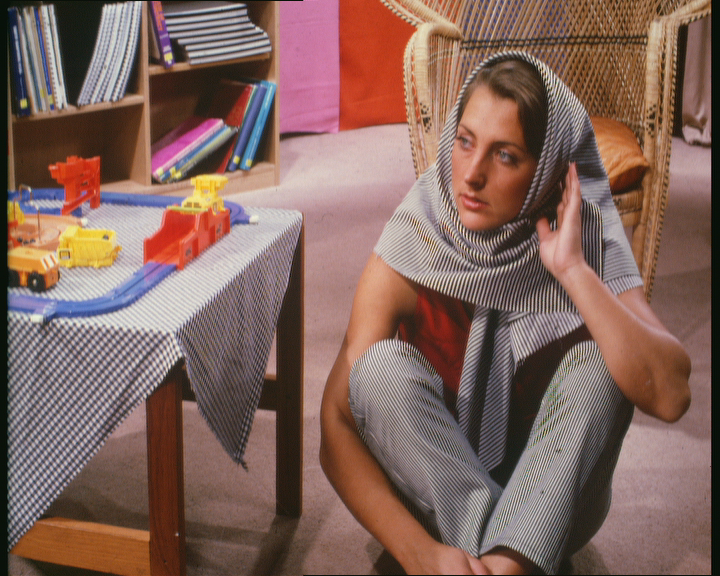

In [4]:
# Load barbara image with the TestImages package
s = RGB{Float64}.(testimage("barbara_color"))

# Example 1: Frequency adjustment

The following example shows how this package can be used to adjust the frequencies of an image:

In [5]:
# Define wave detection parameters (see Spectral Remapping paper for details,
# at https://www.inf.ufrgs.br/~eslgastal/SpectralRemapping/)
detection_parameters = (;
    R = 4, # Expected image downscaling factor
    σ = 3, # Gaussian window standard deviation, in pixels
)

(R = 4, σ = 3)

Solving the linear system.
  0.024505 seconds (52 allocations: 24.834 MiB)
  3.026969 seconds (38.98 M allocations: 2.551 GiB, 14.02% gc time, 1.67% compilation time)


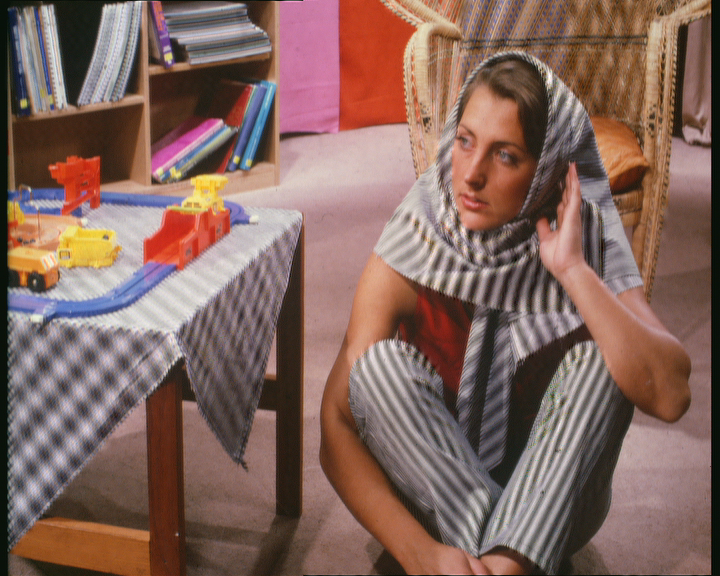

In [7]:
# NOTE: For accurate timing data, you should run this and other code blocks at
# least twice, since on the first call of each function Julia spends some time
# compiling the code.

@time s_0p25 = adjust(s, 0.25; detection_parameters...)

# Example 2: Frequency adjustment with pre-computed information

To perform several frequency adjustments of the same image more efficiently, one should pre-compute the wave/frequency detection and phase unwrapping steps using a `FrequencyAdjuster` object, as shown in the following example:

In [11]:
# The constructor of the FrequencyAdjuster object performs the wave detection
# step for the signal s and stores the resulting data into F.data[:waves]
@time F = FrequencyAdjuster(s; detection_parameters...)

  1.041624 seconds (24.14 M allocations: 1.065 GiB, 2.63% gc time)


FrequencyAdjuster{Float64}

In [12]:
# Unwrap the phases to obtain the smooth phase functions (see our paper for
# details) and stores the resulting data into F.data[:u_all]
@time phaseunwrap!(F);

Solving the linear system.
  0.024071 seconds (52 allocations: 24.834 MiB)
  1.532687 seconds (14.62 M allocations: 1.442 GiB, 9.74% gc time)


  0.123563 seconds (157.06 k allocations: 40.157 MiB, 3.17% compilation time)


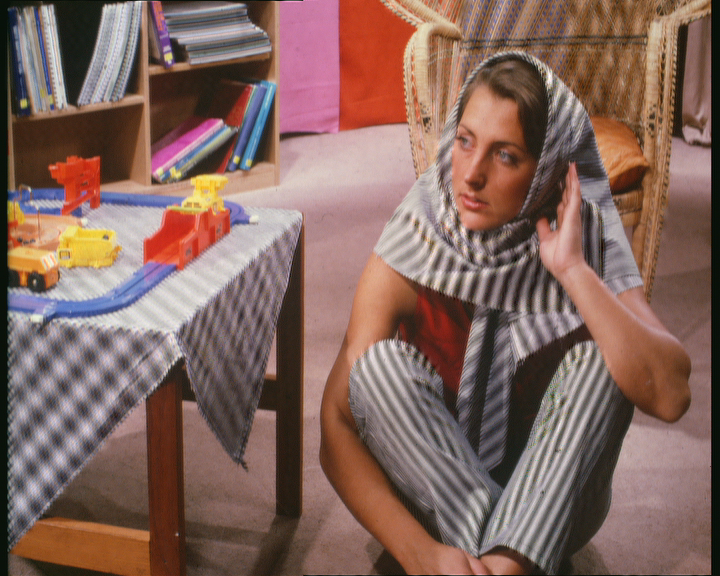

In [13]:
# Reconstruct the image adjusting frequencies
@time s_0p25 = adjust(F, 0.25) # Reconstructs the image adjusting frequencies by 0.25

# Example 3: Frequency adjustment using the GPU (via CUDA)

It is also possible to use a GPU with CUDA support to adjust the image content. To use the GPU it is necessary to first have the *CUDA.jl* package installed and loaded, and then call the `cu_adjust` or `cu_adjust_rgb` methods, or the `adjust` and `adjust_rgb` methods with a `cuFrequencyAdjuster` object, as in the example below:

In [ ]:
# WARNING: CUDA.jl is a big download!
Pkg.add("CUDA")

In [23]:
using CUDA

In [24]:
# On first run this will initialize CUDA
@time cu_F = cuFrequencyAdjuster(F);

  0.082216 seconds (1.45 M allocations: 66.269 MiB)


  0.085102 seconds (215 allocations: 12.391 KiB)


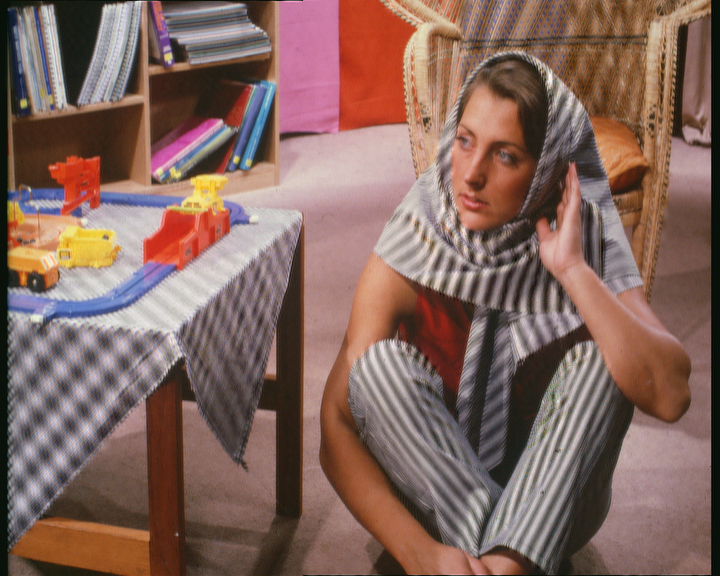

In [25]:
@time d_s_0p25 = cu_adjust(cu_F, 0.25);
Array(d_s_0p25) # Copy data from device (GPU) to CPU memory